Most Important Feature: BurnoutLevel (Score: 0.6356)


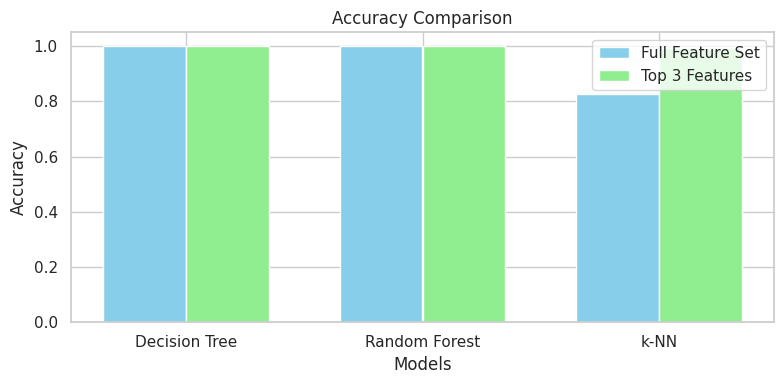

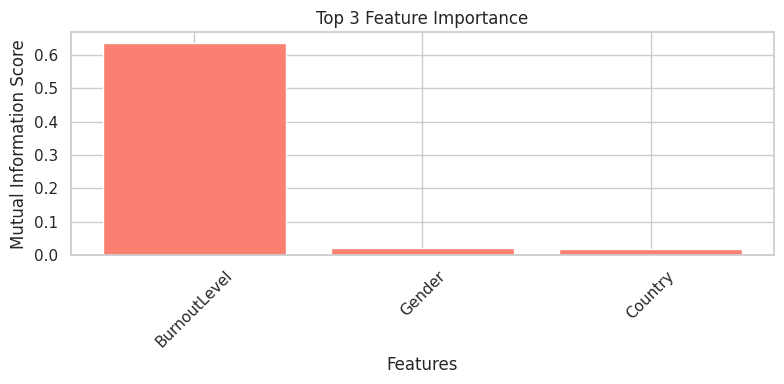

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Load data
data = pd.read_csv("./mental_health_workplace_survey.csv")

# Drop not needed columns
data = data.drop(columns=["EmployeeID"])

# Defining target and features
X = data.drop("BurnoutRisk", axis=1)
y = data["BurnoutRisk"]

# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

categorical_features = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Impute missing values
for col in categorical_features:
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_valid[col].fillna(X_train[col].mode()[0], inplace=True)

for col in numerical_features:
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_valid[col].fillna(X_train[col].median(), inplace=True)

# Encoding variables
encoder = OrdinalEncoder()
X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
X_valid[categorical_features] = encoder.transform(X_valid[categorical_features])

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 3 model Feature Training
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "k-NN": KNeighborsClassifier()
}

results_full = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    y_proba = model.predict_proba(X_valid_scaled)[:, 1]

    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)

    results_full[name] = {"Accuracy": acc, "ROC AUC": roc_auc}

# Top 3 Feature selection using Mutual Information
selector = SelectKBest(score_func=mutual_info_classif, k=3)
selector.fit(X_train_scaled, y_train)

feature_names = X_train.columns
mutual_info_scores = selector.scores_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Score': mutual_info_scores})
top_features = feature_importance.nlargest(3, 'Score')

# Most important feature
most_important_feature = top_features.iloc[0]['Feature']
print(f"Most Important Feature: {most_important_feature} (Score: {top_features.iloc[0]['Score']:.4f})")

# Filtering the features
selected_features_mask = selector.get_support()
X_train_selected = X_train_scaled[:, selected_features_mask]
X_valid_selected = X_valid_scaled[:, selected_features_mask]

# Scale selected features
X_train_top_scaled = scaler.fit_transform(X_train_selected)
X_valid_top_scaled = scaler.transform(X_valid_selected)

results_top3 = {}

for name, model in models.items():
    model.fit(X_train_top_scaled, y_train)
    y_pred = model.predict(X_valid_top_scaled)
    y_proba = model.predict_proba(X_valid_top_scaled)[:, 1]

    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)

    results_top3[name] = {"Accuracy": acc, "ROC AUC": roc_auc}

# Comparison with bar graphs
models = list(models.keys())
full_acc = [results_full[model]["Accuracy"] for model in models]
top3_acc = [results_top3[model]["Accuracy"] for model in models]
full_roc = [results_full[model]["ROC AUC"] for model in models]
top3_roc = [results_top3[model]["ROC AUC"] for model in models]

# Bar graph
plt.figure(figsize=(8, 4))
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, full_acc, bar_width, label="Full Feature Set", color='skyblue')
plt.bar(index + bar_width, top3_acc, bar_width, label="Top 3 Features", color='lightgreen')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.tight_layout()
plt.show()

# graph for Top 3 Feature Importance
plt.figure(figsize=(8, 4))
plt.bar(top_features['Feature'], top_features['Score'], color='salmon')
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Top 3 Feature Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

